# Présentation du Notebook
#### Ce notebook est là pour :
    - trouver les statistiques (longueurs des textes, des lignes, distributions des langues) adaptés à mon Corpus 
    - nettoyer (avec suppression de données abérrentes) 
    - augmenter les données
    - avoir des visualisations 

#### A partir du corpus de référence choisi, les stats réalisées pour prouver la qualité du corpus sont :
    - Taille du corpus : 42 362 lignes
    - Diversité linguistique : 10 langues différentes
    - Distribution des langues : une distribution qui se veut équilibrée (la moins représentée (russe) correspond à 9,7 % du corpus et la plus représentée (espagnol) correspond à 10,4 %)
    - Distribution de la longueur de chaque ligne de texte

In [ ]:
# On va donc également les calculer pour mon corpus 

In [3]:
# On importe les bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

In [4]:
import jupyter_black

jupyter_black.load()

In [5]:
# Lecture du fichier TSV
df = pd.read_csv("../data/clean/donnees.tsv", sep="\t")

In [6]:
# Taille du corpus = nombre de lignes
taille_corpus = len(df)
print("Nombre de lignes :", taille_corpus)

Nombre de lignes : 2593


#### Nombre de lignes de mon corpus beaucoup plus faible que le corpus de référence, mais ce n'est pas grave, la prof a dit qu'on avait pas besoin d'en prendre beaucoup.

In [7]:
# Diversité linguistique

# Obtenir le nombre de valeurs uniques dans la colonne 2 : language_code
nombre_de_valeurs_uniques = df["language_code"].nunique()

print("Nombre de langues différentes :", nombre_de_valeurs_uniques)

# Obtenir toutes les valeurs uniques de la colonne 2
valeurs_uniques = df["language_code"].unique()

print("Toutes les langues (code ISO 639) :", valeurs_uniques)

Nombre de langues différentes : 45
Toutes les langues (code ISO 639) : ['th' 'el' 'yue' 'pa-guru' 'bg' 'gl' 'eu' 'ro' 'es' 'ckb' 'cs' 'ca' 'fa'
 'hu' 'it' 'mhr' 'de' 'fr' 'he' 'sl' 'sv' 'uk' 'pl' 'pt' 'ar' 'ur' 'ru'
 'id' 'su' 'da' 'sq' 'bs' 'zh' 'nl' 'vi' 'af' 'en' 'ja' 'sk' 'tr' 'lt'
 'cy' 'bar' 'ko' 'sr-cyrl']


In [32]:
# Distribution des langues

# Obtenir la distribution des valeurs dans la colonne 2 : language_code
distribution_valeurs = df["language_code"].value_counts()

print("Distribution des langues dans le Corpus :\n", distribution_valeurs)

# Sauvegarde les métriques de distribution des langues
distribution_valeurs.to_csv("../results/distribution_langues_corpus.csv")

Distribution des langues dans le Corpus :
 uk         367
en         289
ar         272
cs         263
ru         106
ko         103
fr          96
de          95
sr-cyrl     84
ca          81
it          71
es          68
gl          68
fa          60
eu          59
sq          49
pt          46
da          32
ro          32
he          29
id          28
pl          26
sl          24
bg          23
hu          22
vi          20
el          17
nl          17
af          15
bs          15
su          13
ckb         12
bar         11
zh          11
cy          10
pa-guru     10
th          10
lt           8
ja           7
sv           7
yue          6
tr           4
sk           3
mhr          3
ur           1
Name: language_code, dtype: int64


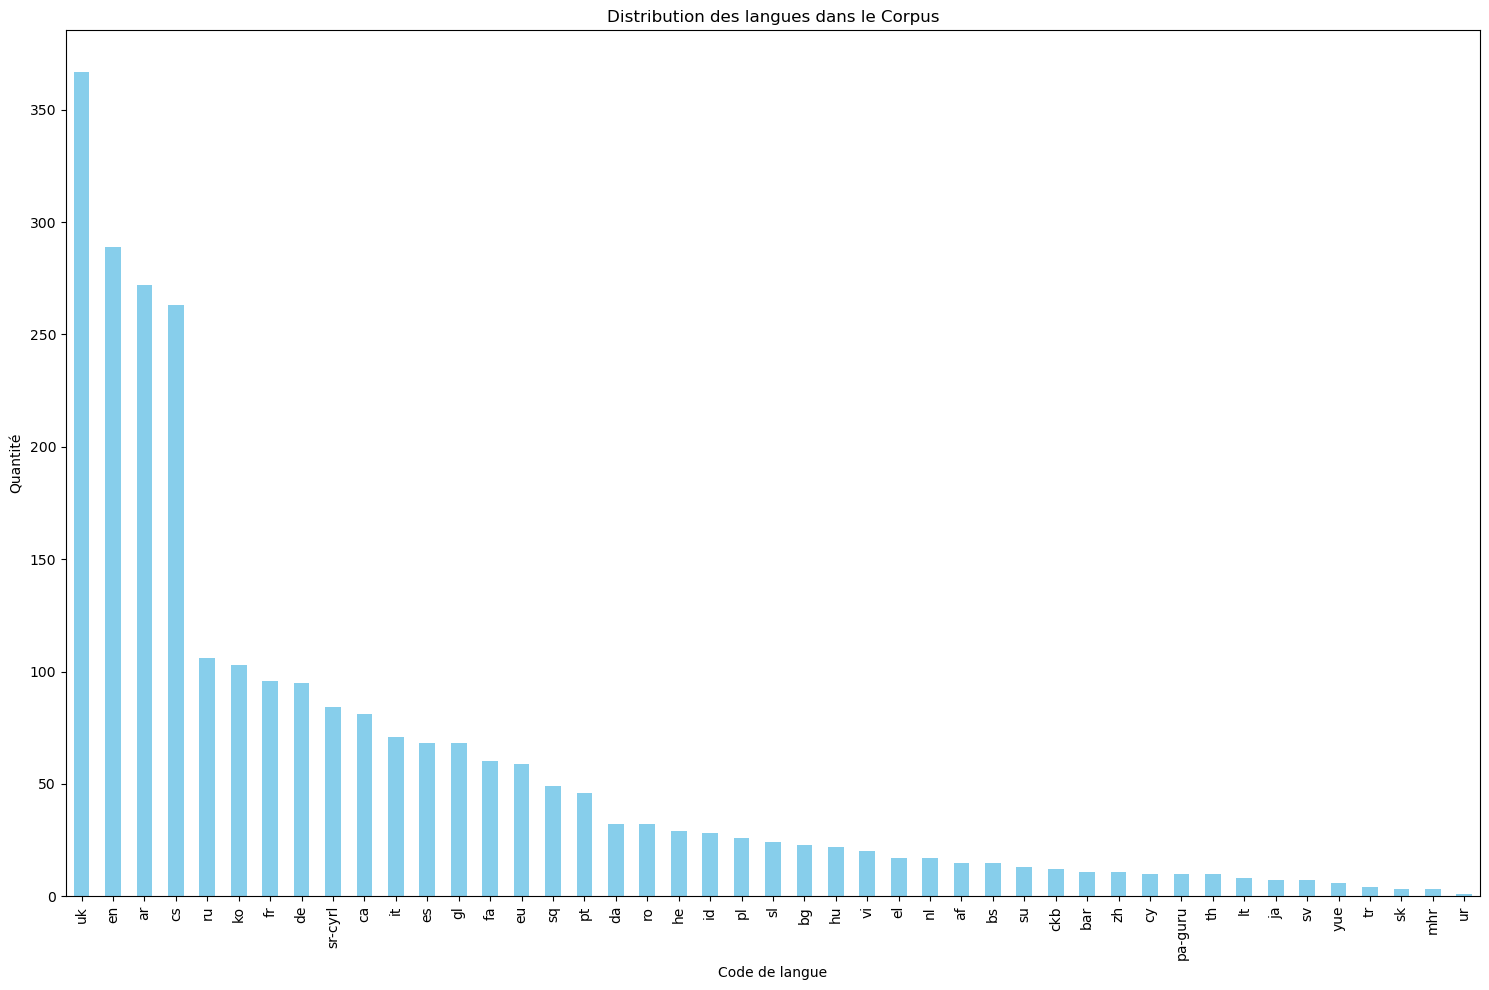

In [16]:
# Création du graphique en barres
plt.figure(figsize=(15, 10))
distribution_valeurs.plot(kind="bar", color="skyblue")
plt.xlabel("Code de langue")
plt.ylabel("Quantité")
plt.title("Distribution des langues dans le Corpus")
plt.xticks(
    rotation=90
)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig("../results/distribution_langues_avant_nettoyage_augmentation.png")

# Affichage du graphique
plt.show()

#### On y voit un très grand déséquilibre entre les quantités de données pour chaque langue : il faudra nettoyer (supprimer celles qui en ont le moins) et augmenter les quantités de données dont les langues qu'on conserve sont les plus faibles (avec de la génération).

In [34]:
# Calculer le nombre total de lignes dans le corpus
total_lignes = len(df)

# Calculer la proportion de chaque langue (on multiplie par 100 pour avoir le résultat en pourcentage)
proportion_langues = (df["language_code"].value_counts() / total_lignes) * 100

print("Proportion des langues dans le Corpus :\n", proportion_langues)

# Sauvegarde les métriques de distribution des langues en pourcentage
proportion_langues.to_csv("../results/pourcentage_langues_corpus.csv")

Proportion des langues dans le Corpus :
 uk         14.153490
en         11.145391
ar         10.489780
cs         10.142692
ru          4.087929
ko          3.972233
fr          3.702275
de          3.663710
sr-cyrl     3.239491
ca          3.123795
it          2.738141
es          2.622445
gl          2.622445
fa          2.313922
eu          2.275357
sq          1.889703
pt          1.774007
da          1.234092
ro          1.234092
he          1.118396
id          1.079830
pl          1.002700
sl          0.925569
bg          0.887003
hu          0.848438
vi          0.771307
el          0.655611
nl          0.655611
af          0.578481
bs          0.578481
su          0.501350
ckb         0.462784
bar         0.424219
zh          0.424219
cy          0.385654
pa-guru     0.385654
th          0.385654
lt          0.308523
ja          0.269958
sv          0.269958
yue         0.231392
tr          0.154261
sk          0.115696
mhr         0.115696
ur          0.038565
Name: language

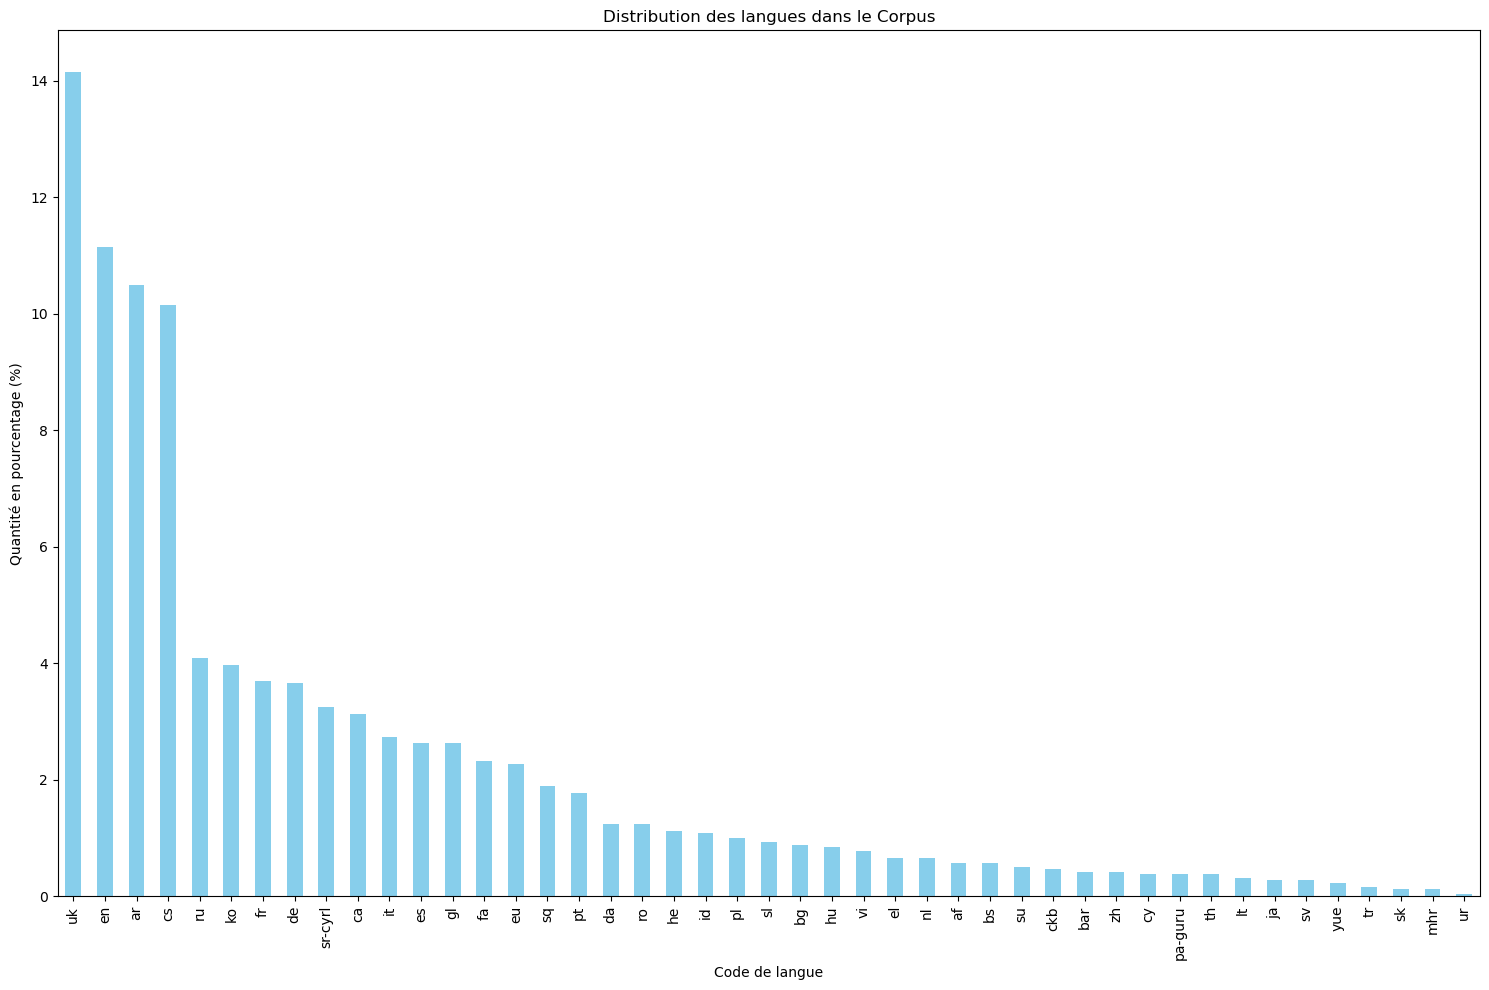

In [28]:
# Création du graphique en barres
plt.figure(figsize=(15, 10))
proportion_langues.plot(kind="bar", color="skyblue")
plt.xlabel("Code de langue")
plt.ylabel("Quantité en pourcentage (%)")
plt.title("Distribution des langues dans le Corpus")
plt.xticks(
    rotation=90
)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig("../results/pourcentage_langues_avant_nettoyage_augmentation.png")

# Affichage du graphique
plt.show()

#### Beaucoup plus de langues que le corpus de référence (45 vs. 10) mais une distribution de celles-ci beaucoup moins équitable...
#### Peut-être nettoyer : supprimer les langues pour lesquelles on a trop peu de lignes de textes
#### Une distribution équilibrée des langues est souhaitable pour garantir que le système de détection de la langue est capable de traiter toutes les langues de manière égale (important pour l'entrainement par exemple). 

In [35]:
# Définir une fonction qui calcule la longueur de chaque chaîne de caractères dans la colonne 1
def longueur_et_valeur(chaine):
    return len(chaine), chaine


# Appliquer la fonction à chaque chaîne de caractères dans la colonne 1
resultat = df["text"].apply(longueur_et_valeur)

# Créer un DataFrame à partir des résultats
resultat_df = pd.DataFrame(resultat.tolist(), columns=["Longueur", "Valeur"])

# Obtenir la distribution des longueurs de chaînes de caractères
distribution_longueurs = resultat_df["Longueur"].value_counts()

# Sauvegarde les métriques de distribution des longueurs de chaque ligne de texte
distribution_longueurs.to_csv("../results/distribution_longueurs_corpus.csv")

In [21]:
print("Distribution des longueurs de chaque ligne de texte :\n", distribution_longueurs)

Distribution des longueurs de chaque ligne de texte :
 50      23
32      21
5       19
8       17
89      16
        ..
307      1
796      1
329      1
1085     1
1190     1
Name: Longueur, Length: 648, dtype: int64


#### Colonne 1 = Longueur 
#### Colonne 2 = Nombre de ligne avec cette longueur de texte
#### Exemple :
    - 23 lignes font 50 caractères
    - 21 lignes font 32 caractères

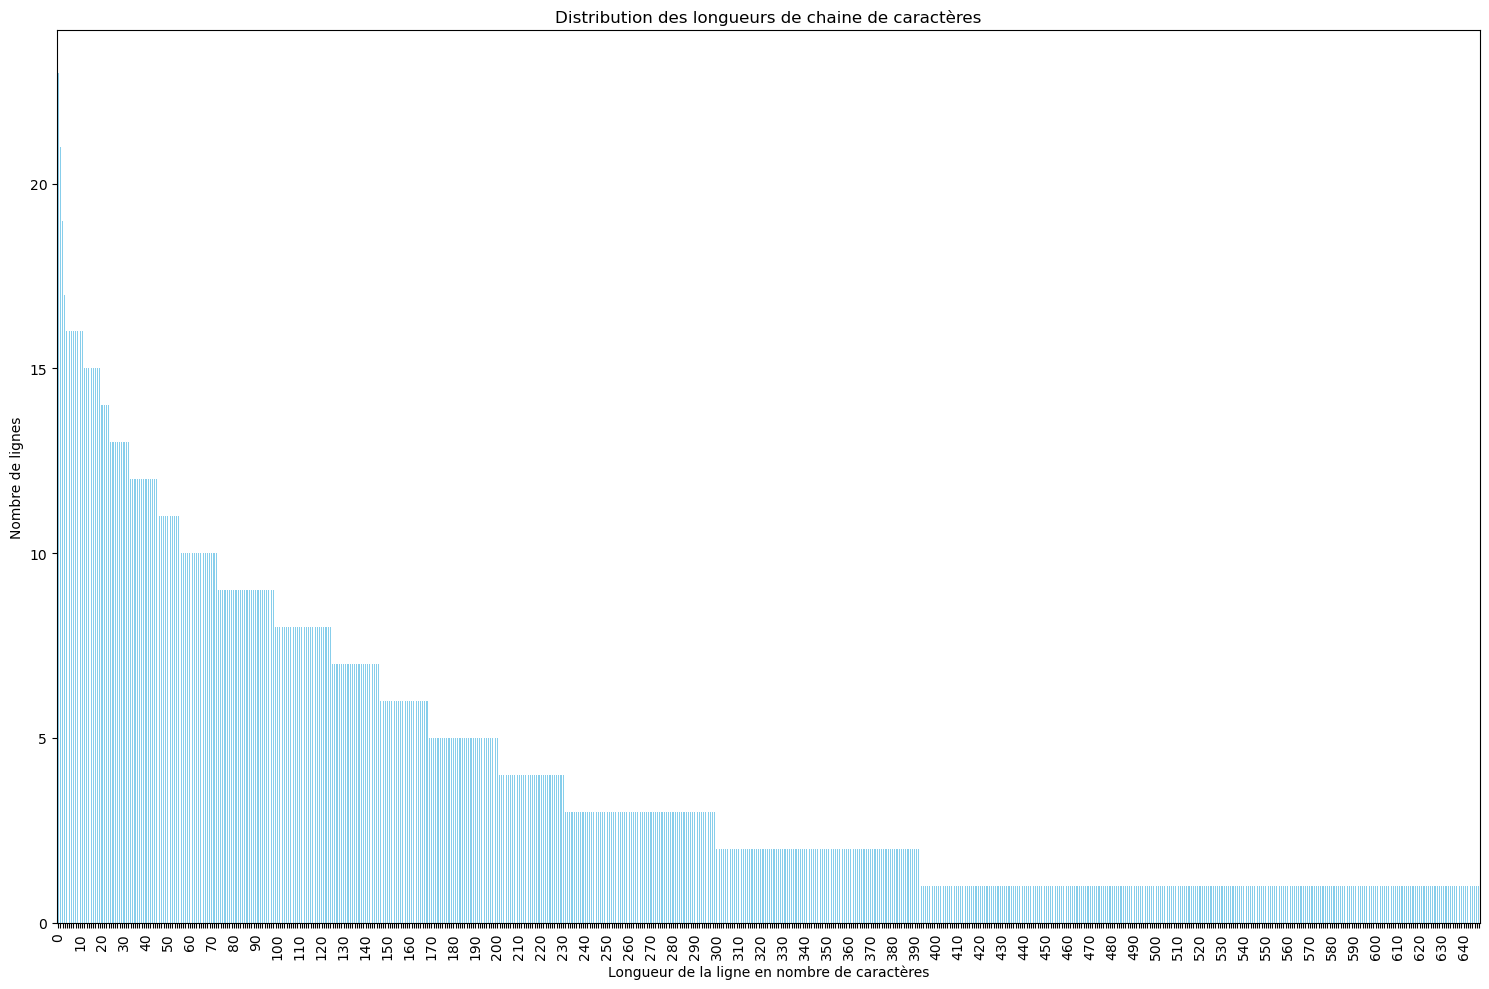

In [27]:
# Création du graphique en barres
plt.figure(figsize=(15, 10))
distribution_longueurs.plot(kind="bar", color="skyblue")
plt.xlabel("Longueur de la ligne en nombre de caractères")
plt.ylabel("Nombre de lignes")
plt.title("Distribution des longueurs de chaine de caractères")

# Sélectionner un sous-ensemble des labels pour l'axe x pour plus de lisibilité (ici on affiche pas tous les labels en abscisse car il y a trop de lignes)
N = 10  # Afficher chaque N-ième label
indices = range(len(distribution_longueurs))
labels = [index if i % N == 0 else "" for i, index in enumerate(indices)]
plt.xticks(
    indices, labels, rotation=90
)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité

plt.tight_layout()

# Sauvegarder le graphique
plt.savefig("../results/distribution_longueurs_avant_nettoyage_augmentation.png")

# Affichage du graphique
plt.show()

In [13]:
print("Les lignes de textes (valeur) avec leur longueur :\n", resultat_df)

Les lignes de textes (valeur) avec leur longueur :
       Longueur                                             Valeur
0         2613  เอนโทรปีของข้อมูล - วิกิพีเดียข้ามไปเนื้อหาเมน...
1            9                                          2491(ค.ศ.
2          832  1948) ชื่อA Mathematical Theory of Communicati...
3          369  }นั่นคือ เอนโทรปีของเหตุการณ์ x คือ ผลรวม (บนท...
4         1173  }เมื่อ K เป็นค่าคงตัวใดๆ (และจะเห็นได้ว่ามันเป...
...        ...                                                ...
2588       168  Springer.ISBN978-1556080104.Introduction to en...
2589       646  Open access.Description of information entropy...
2590        89  Information Theory for Intelligent PeopleАрхив...
2591      1190  Short introduction to the axioms of informatio...
2592       181  Погледајтеуслове коришћењаза детаље.Политика п...

[2593 rows x 2 columns]


In [36]:
# Sauvegarde des textes et de leur longueur
resultat_df.to_csv("../results/textes_longueurs.csv")

In [38]:
# Compter le nombre de lignes pour chaque longueur
distribution_longueurs_sorted = distribution_longueurs.sort_index()

# Calculer la proportion de chaque longueur par rapport au nombre total de lignes
proportion_longueurs = distribution_longueurs_sorted / len(df)

# Créer un DataFrame pour la distribution des longueurs et des proportions
distribution_df = pd.DataFrame(
    {"Quantité": distribution_longueurs_sorted, "Proportion": proportion_longueurs}
)

print("Distribution des longueurs de texte de chaque ligne :\n", distribution_df)

Distribution des longueurs de texte de chaque ligne :
       Quantité  Proportion
2            8    0.003085
3           15    0.005785
4           14    0.005399
5           19    0.007327
6            9    0.003471
...        ...         ...
3823         1    0.000386
4766         1    0.000386
5105         1    0.000386
5178         1    0.000386
5211         1    0.000386

[648 rows x 2 columns]


In [39]:
# Sauvegarde les métriques de distribution des longueurs de texte de chaque ligne
distribution_df.to_csv("../results/distribution_longueur_quantite_proportion.csv")

#### Pour mon corpus, j'ai donc :
    - Taille du corpus : 2 593 lignes
    - Diversité linguistique : 45 langues différentes
    - Distribution des langues : une distribution qui n'est pas vraiment équilibrée (peut-être un nettoyage à faire pour conserver moins de langues, mais avoir une distribution plus équitable ?)
    - Distribution de la longueur de chaque ligne de texte

#### Passons maintenant au nettoyage (avec suppression de données abérrentes) et à l'augmentation de données au besoin :
    - Comme on l'a vu, il y a une grande disparité dans la quantité de donnée
            - On va donc garder seulement les langues qui ont assez de données pour travailler dessus
                - On a vu les proportions des différentes langues, on décide de garder celles qui ont une représentation de plus de 10% : on garde donc `uk`, `en`, `ar`, `cs`
            - On va augmenter les données des langues qu'on garde et qui ont le moins de données

In [40]:
# Conserver seulement les quatre premières lignes
proportion_langues_top4 = proportion_langues.head(4)
print("Proportion des 4 premières langues dans le Corpus :\n", proportion_langues_top4)

Proportion des 4 premières langues dans le Corpus :
 uk    14.153490
en    11.145391
ar    10.489780
cs    10.142692
Name: language_code, dtype: float64


In [43]:
distribution_langues_top4 = distribution_valeurs.head(4)
print("Distribution 4 premières langues dans le Corpus :\n", distribution_langues_top4)

Distribution 4 premières langues dans le Corpus :
 uk    367
en    289
ar    272
cs    263
Name: language_code, dtype: int64


In [48]:
# Liste des valeurs spécifiques qu'on veut garder
valeurs_a_garder = ["uk", "en", "ar", "cs"]

# Filtrer le DataFrame
df_filtre = df[df["language_code"].isin(valeurs_a_garder)]

# Afficher le DataFrame filtré
print(df_filtre)

                                                   text language_code
305   Informační entropie – WikipediePřeskočit na ob...            cs
306   Informační entropie je obecně průměrné množstv...            cs
307   [1]Když datový zdroj vyprodukuje hodnotu (symb...            cs
308   nastane událost s nízkou pravděpodobností), ne...            cs
309   Pokud množství informace, které nese každá udá...            cs
...                                                 ...           ...
2358  (2003),Information Theory, Inference and Learn...            en
2359  Cambridge University Press.ISBN978-0-521-17738...            en
2360  Open access.vteData compressionmethodsLossless...            en
2361  By using this site, you agree to theTerms of U...            en
2362  Wikipedia® is a registered trademark of theWik...            en

[1191 rows x 2 columns]


In [51]:
# Vérifier la nouvelle distribution des étiquettes
print(df_filtre["language_code"].value_counts())

uk    367
en    289
ar    272
cs    263
Name: language_code, dtype: int64


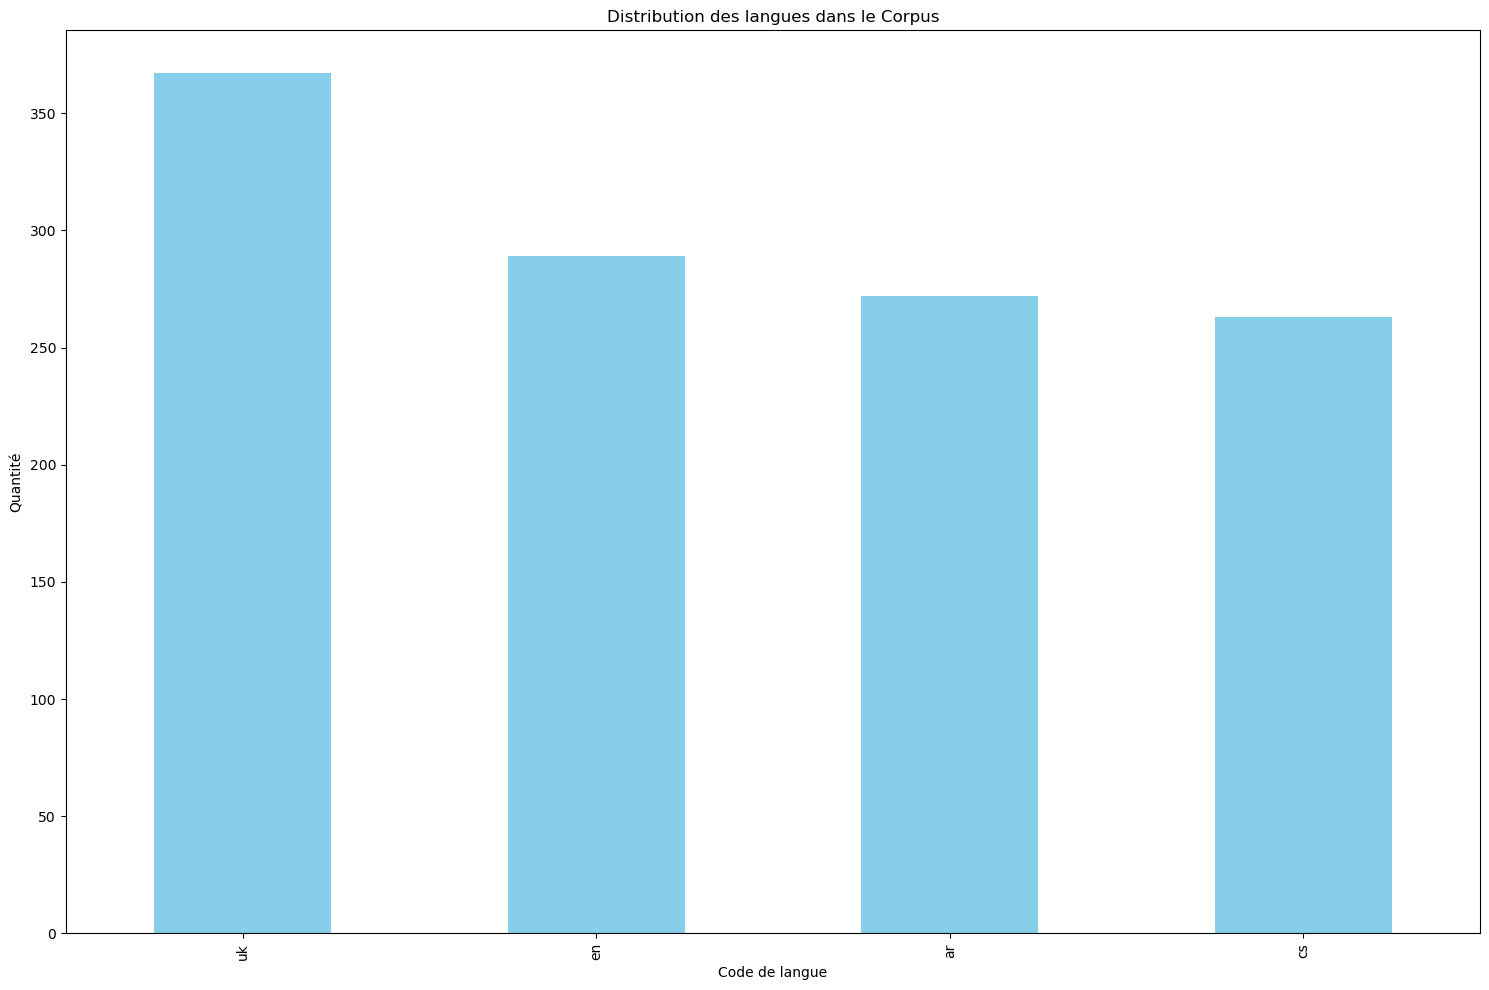

In [59]:
# Création du graphique en barres
plt.figure(figsize=(15, 10))
df_filtre["language_code"].value_counts().plot(kind="bar", color="skyblue")
plt.xlabel("Code de langue")
plt.ylabel("Quantité")
plt.title("Distribution des langues dans le Corpus")
plt.xticks(
    rotation=90
)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig("../results/distribution_languesTop4_avant_nettoyage_augmentation.png")

# Affichage du graphique
plt.show()

In [52]:
def augment_underrepresented_labels(
    data: pd.DataFrame, text_col: str, label_col: str, threshold: int
) -> pd.DataFrame:
    """
    Augmente les étiquettes sous-représentées dans un DataFrame en utilisant RandomOverSampler.

    Parameters:
    - data (pd.DataFrame): Le DataFrame contenant les colonnes de texte et d'étiquettes.
    - label_col (str): Le nom de la colonne contenant les étiquettes.
    - text_col (str): Le nom de la colonne contenant les textes.
    - threshold (int): Le seuil minimal du nombre d'échantillons par étiquette.

    Returns:
    - pd.DataFrame: Le DataFrame augmenté.
    """
    # Obtenir le nombre d'échantillons par étiquette
    label_counts = data[label_col].value_counts()

    # Créer une stratégie de sur-échantillonnage pour les étiquettes sous-représentées
    sampling_strategy = {
        label: threshold for label, count in label_counts.items() if count < threshold
    }

    # Vérifier si des étiquettes sous-représentées existent
    if not sampling_strategy:
        print("Aucune étiquette sous-représentée trouvée.")
        return data

    # Isoler les textes et les étiquettes
    X = data[[text_col]]
    y = data[label_col]

    # Utiliser RandomOverSampler pour augmenter les étiquettes sous-représentées
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Créer un nouveau DataFrame avec les données augmentées
    augmented_data = pd.DataFrame(
        {label_col: y_resampled, text_col: X_resampled[text_col]}
    )

    return augmented_data

In [55]:
# Utiliser la fonction pour augmenter les étiquettes ayant moins de 367 échantillons
augmented_data = augment_underrepresented_labels(
    df_filtre, "text", "language_code", 367
)

# augmented_data.to_csv("../../data/csv/augmented_data.csv", index=False)


# Vérifier la nouvelle distribution des étiquettes
donnees_augmentees = augmented_data["language_code"].value_counts()
print(donnees_augmentees)

cs    367
uk    367
ar    367
en    367
Name: language_code, dtype: int64


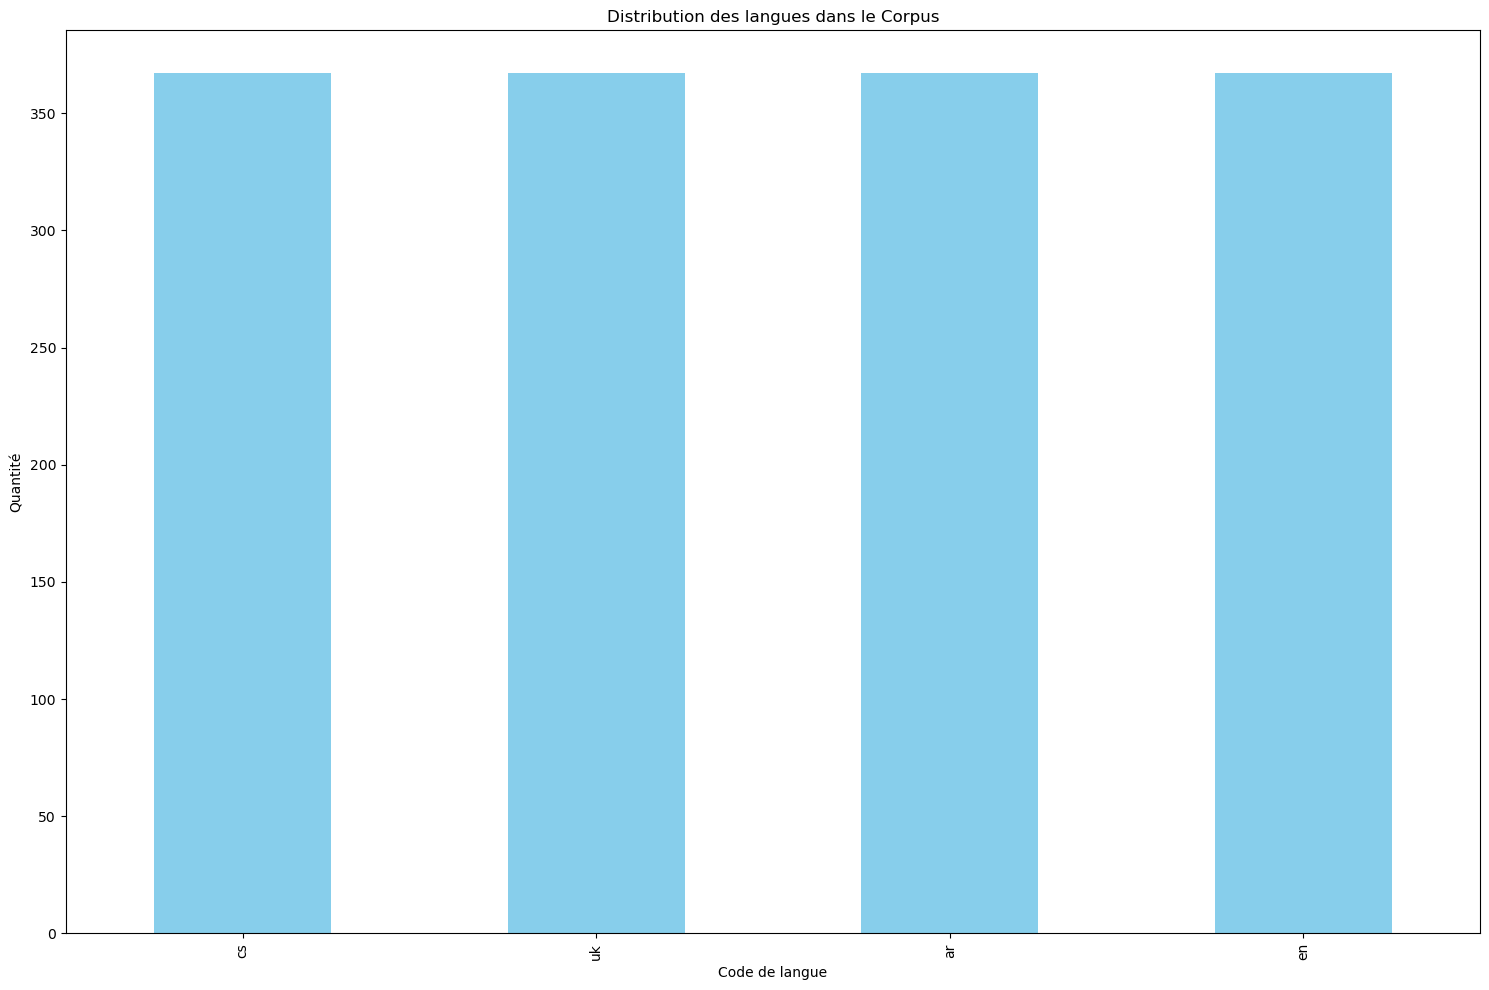

In [60]:
# Création du graphique en barres
plt.figure(figsize=(15, 10))
donnees_augmentees.plot(kind="bar", color="skyblue")
plt.xlabel("Code de langue")
plt.ylabel("Quantité")
plt.title("Distribution des langues dans le Corpus")
plt.xticks(
    rotation=90
)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig("../results/distribution_langues_apres_nettoyage_augmentation.png")

# Affichage du graphique
plt.show()

#### On voit bien que les données ont été augmentées conformément à ce qu'on souhaitait, à savoir que toutes les langues qu'on a gardé aient la même quantité de données que la langue la plus dotée

In [63]:
# Convertir la Series en DataFrame (si nécessaire)
if isinstance(donnees_augmentees, pd.Series):
    donnees_augmentees = pd.DataFrame(donnees_augmentees)

In [64]:
from datasets import Dataset

# Création d'un dataset à partir d'un DataFrame
dataset = Dataset.from_pandas(donnees_augmentees)

In [80]:
print(type(donnees_augmentees))

<class 'pandas.core.frame.DataFrame'>


In [81]:
print(donnees_augmentees.columns)

Index(['language_code'], dtype='object')


In [82]:
donnees_augmentees

,language_code
cs,367
uk,367
ar,367
en,367
